In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

# A short interactive guide to brio

In this example we will construct SAILnet (Zylderberg et al, 2011), a simple network for performing sparse inference with local learning rules.

SAILnet consists of a single layer of leaky integrate and fire neurons that receive input from a stimulus (an image in this case) and send inhibition to each other. 

## brio architecture

All networks in brio are made out of two elements: Layers and Connections. 

A Layer holds state for a population of neurons. Layers can be excitatory, inhibitory or neither. The Layer class does not implement a specific neural model, giving significant wigggle room to subclasses. Implemented sublcasses include neural models for discrete LIF neurons and Boltzmann Machines.

Connection objects hold state for the weights connecting Layers. By design, Connection objects only have access to information about the Layers they connect, thus the learning rules implemented by Connection subclasses are necessarily local. 

Network objects hold pointers to the comprising Layers and Connections in addition to global utility methods to train the network and display progress plots.

Although brio is primarily an experimental platform and was designed to support arbitrary network topologies with SAILnet-like models, it has significant utility as a general purpose neural network library. 

## Instantiating networks in brio

To build a network in brio, first instantiate the different layers that are part of the network. 

For SAILnet we need two layers: an input layer whose only role is to hold the input stimuli, and a LIF layer. Let's create them:

In [2]:
from brio.blocks import layer

# creates an InputLayer with 17**2 neurons
input_layer = layer.InputLayer(17**2, label='input layer')

# creates a LIFLayer with 20**2 neurons
lif_layer = layer.LIFLayer(20**2, label='lif layer')

The size of Layers must be specified when instantiated. Additionally several optional paramaters may be passed specifying a label, layer type (unconstrained (default), excitatory, inhibitory) or various flags. Subclasses may take additional parameters. Refer to the Layer docstring for details.

The next step is to specify the connectivity structure of the network by instantiating the required Connections. 

SAILnet has two connections: a feedforward connection from the input to the LIF population and a recurrent connection on the LIF population. The former updates its set of weights using Oja's rule whereas the latter uses Foldiak's rule.

In [3]:
from brio.blocks import connection

ffwd_con = connection.OjaConnection(input_layer, lif_layer, label='ffwd connection')
recrnt_con = connection.FoldiakConnection(lif_layer, lif_layer, label='recrnt connection')

An input layer and output layer must be passed when instantiating connection objects. Optionally and additionally one may pass a label, a learning rate multiplier, and toggle to select a weight instantiation scheme. 

The last step to creating a network is to pass the layers to a Network object.

In [4]:
from brio.blocks.network import Network
from brio.blocks.aux import NetworkParams

# Network.__init__ expects a list of Layer objects
layers = [input_layer, lif_layer]

sailnet = Network(layers, params=NetworkParams())

There are two things to notice here:

Firstly, that I did not pass the connections to Network! This is not necessary as Connections add pointers to themselves to the Layers they connect when instantiated. Thus the network graph is stored in a decentralized fashion as a graph of pointers. 

Secondly, that I pass a NetworkParams object to Network. This object is nothing more than a dumb container class, designed to store global parameters. 

## Training networks

We can now begin training the model we have built. In this case we will train our model on a set of whitened natural scenes included in the repo for convenience.

In [5]:
from scipy.io import loadmat
from brio.misc.patches import patch_generator

data_path = "../data/whitened_van_hateren.mat"
images = loadmat(data_path)["IMAGES"]

# trains the model on 1000 17x17 image patches extracted from the set of images
# train expects an iterator over arrays that can be cast to the same shape as the input layer
sailnet.train(patch_generator(images, 17, 1000))

Training iteration: 100 

Average firing rates:
lif layer: 0.0




Training iteration: 200 

Average firing rates:
lif layer: 0.0




Training iteration: 300 

Average firing rates:
lif layer: 0.0198921568627




Training iteration: 400 

Average firing rates:
lif layer: 5.37376470588




Training iteration: 500 

Average firing rates:
lif layer: 9.20796078431




Training iteration: 600 

Average firing rates:
lif layer: 9.1878872549




Training iteration: 700 

Average firing rates:
lif layer: 8.42435784314




Training iteration: 800 

Average firing rates:
lif layer: 8.38520098039




Training iteration: 900 

Average firing rates:
lif layer: 7.02749019608




Training iteration: 1000 

Average firing rates:
lif layer: 6.86138235294

Weight distribution for recrnt connection
0.9 |                                                                                                     
0.8 |                                                                                                 

By default, brio prints some summary statistics as training progreses. Several more sophisticated options for online plotting of receptive fields and parameter distributions are provided in `brio.misc.plotting`, and also controlled by a toggle in Network.


### Batch updates and built-in notion of timescale

For purposes of stability and efficiency training proceeds in batches of size 100 (by default). That is, instead of being applied after each image presentation, weight updates are accumulated and applied at the end of each batch.

Because brio was built as a platform primarily for experimentation with local LIF networks, a notion of timescale is built into the package. For each stimulus presentation, the network dynamics are run for a fixed number of timesteps. The network's representation for the presented stimulus is encoded in the raster of spikes over that fixed time period. 

For non-spiking models, the network's response over the time period has a different interpretation. For Boltzmann machines for instance, the response would be interpeted as a series of samples of the networks posterior. The number of steps can always be set to one if the network model does not admit a suitable interpretation for such dynamics. 

The training and inference cycle can be summarized in pseudo-code as follows:

    for each batch in the stimulus set:
        for each image in the batch:    
            set the image as the input layer state
            # run the network dynamics:
            for each timestep in the epoch:
                update the network state
            record weight updates
        apply accumulated weight updates
        print summary statistics and/or plots
        
### Visualizing training progress

Since models in brio have so much state, there are quite a lot of statistics one could look to assess if a model is working properly. The most salient features to look at however are usually receptive fields and histograms of network parameters. 

Let's see how to track the development of receptive fields of a model as it trains:

Unfortunately, the class of sailnet-like models tend to be horribly sensitive to hyper-parameters and fickle in their convergence. For this reason, we will not use the model we have just built for this example (as it does not converge). Instead we will use a model I have already fine-tuned, EI-net, which is a close cousin of SAILnet which has separate excitatory and inhibitory populations. See King et. al 2013 for details about EI-net. 

brio provides a factory for this model, which expects a list of layer sizes and a NetworkParams object. 

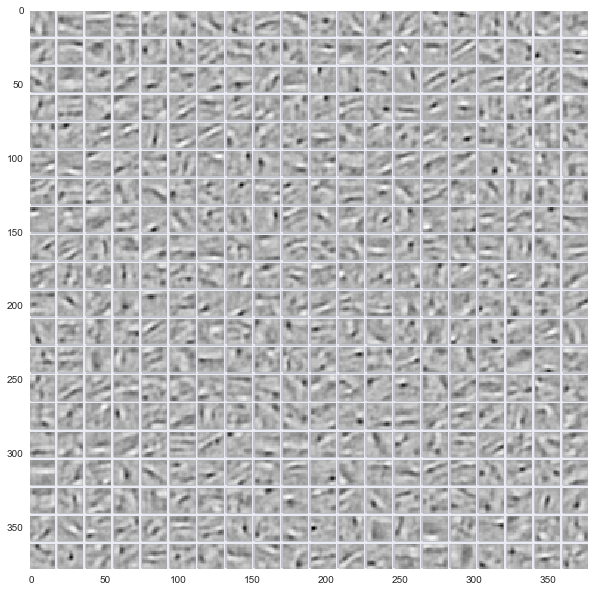

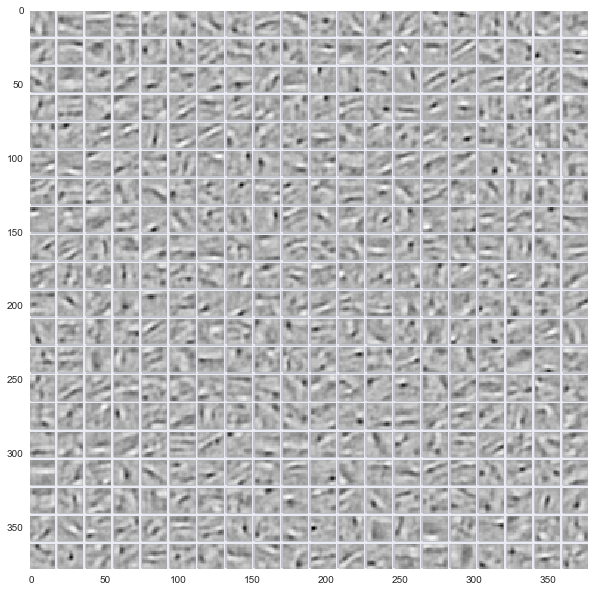

In [13]:
from brio.blocks.factories import einet_factory
from brio.misc.plotting import plot_concat_imgs
from IPython import display

N_EPOCHS = 40
EPOCH_SIZE = 1000
PATCH_SIZE = 17

# specify the layer sizes
layer_sizes = [PATCH_SIZE**2, 20**2, 7**2]

# specify the global parameters
params = NetworkParams()
# changing attributes post initialization is the easiest way to specify params
params.update_cap = 0.1
params.steps_per_rc_time = 10
params.steps_per_fr_time = 10
params.bias_learning_rate = 0.2
params.baseline_lrate = 0.02
params.baseline_firing_rate = 0.02
params.lfr_char_time = 5
# disable printing progess reports to stdout to play nicely with the notebook
params.print_progress = False

# build the model
einet = einet_factory(layer_sizes, params)

# we need an axis object in this scope to rerender plots
fig, ax = plt.subplots(figsize=(10, 10))

for epoch_idx in xrange(N_EPOCHS):
    # train the model for one epoch
    einet.train(patch_generator(images, PATCH_SIZE, EPOCH_SIZE))
    
    # get the new receptive fields
    # nasty trick... see following comments
    oja_w = einet.layers[0].outputs[0].weights.T
    imgs = [w.reshape(PATCH_SIZE, PATCH_SIZE) for w in oja_w]
    
    # if axis is not specified, plot_concat_imgs creates a new one
    # meaning that a new plot window will be created on each iteration 
    # instead of rerendering the same window
    plot_concat_imgs(imgs, axis=ax)
    plt.draw()
    
    # makes updating plot play nicely with the notebook
    # only necessary if working in a notebook
    display.clear_output(wait=True)
    display.display(plt.gcf())